In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.special import inv_boxcox
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from prophet import Prophet
from prophet.plot import plot, plot_components
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [2]:
DATA_PATH = "tsm_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        tsm_hist = pd.read_json(DATA_PATH)
else:
    tsm = yf.Ticker("TSM")
    tsm_hist = tsm.history(period="max")

    tsm_hist.to_json(DATA_PATH)

In [3]:
df_tsm = func.calculate_technical_indicators(tsm_hist)
df_tsm.index = pd.to_datetime(df_tsm.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_tsm_2020 = df_tsm[df_tsm.index >= start_date]
df_tsm_2020

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ema_12,ema_26,macd_line,macd_signal,rsi
2020-01-22 05:00:00,54.007056,54.043730,53.475236,53.502743,8124500,0.0,0.0,53.762937,53.103799,0.659138,0.908278,51.119129
2020-01-23 05:00:00,53.053443,53.245997,51.916451,52.705009,9999200,0.0,0.0,53.600179,53.074259,0.525920,0.831806,37.326678
2020-01-24 05:00:00,53.264333,53.310179,52.686668,52.934238,10402200,0.0,0.0,53.497727,53.063887,0.433839,0.752213,48.028672
2020-01-27 05:00:00,50.999517,51.338782,50.486039,50.669422,9675500,0.0,0.0,53.062603,52.886520,0.176083,0.636987,39.527934
2020-01-28 05:00:00,51.100382,52.374911,50.871150,52.347404,8124400,0.0,0.0,52.952572,52.846585,0.105987,0.530787,44.444440
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-09 04:00:00,146.259995,148.169998,142.949997,145.399994,18488000,0.0,0.0,140.907723,138.104808,2.802914,2.846455,69.696982
2024-04-10 04:00:00,146.630005,148.429993,145.259995,146.220001,18861300,0.0,0.0,141.724996,138.705934,3.019063,2.880977,68.445671
2024-04-11 04:00:00,147.199997,147.559998,144.130005,147.199997,11818800,0.0,0.0,142.567304,139.335124,3.232180,2.951218,66.179553
2024-04-12 04:00:00,145.000000,146.509995,142.149994,142.520004,11981400,0.0,0.0,142.560027,139.571041,2.988987,2.958771,53.594794


In [5]:
tsm_hist_reset = tsm_hist.reset_index()
tsm_hist_reset = tsm_hist_reset.rename(columns={'index': 'ds', 'Close': 'y'})
tsm_prophet_data = tsm_hist_reset[['ds', 'y']].copy()
tsm_prophet_data['ds'] = pd.to_datetime(tsm_prophet_data['ds'])

print(tsm_prophet_data.head())

                   ds         y
0 1997-10-09 04:00:00  3.213321
1 1997-10-10 04:00:00  3.361836
2 1997-10-13 04:00:00  3.287579
3 1997-10-14 04:00:00  3.152564
4 1997-10-15 04:00:00  3.064806


In [8]:
tsm_prophet_data['ds'] = pd.to_datetime(tsm_prophet_data['ds'])
start_date = pd.Timestamp('2020-01-22 05:00:00')
tsm_prophet_2020 = tsm_prophet_data[tsm_prophet_data['ds'] >= start_date]

In [9]:
m = Prophet(weekly_seasonality=True)
m.fit(tsm_prophet_2020)

22:05:31 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing


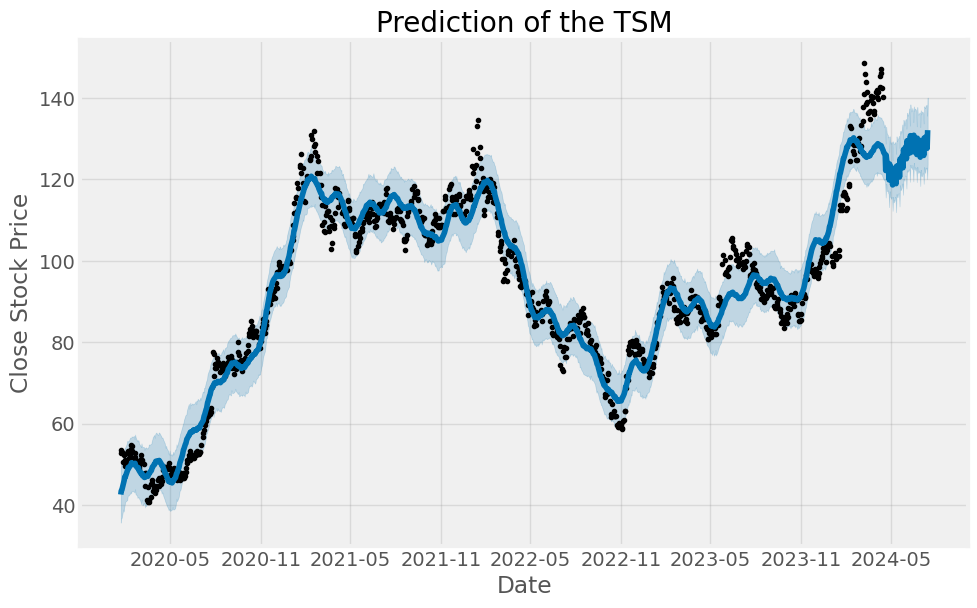

In [10]:
future = m.make_future_dataframe(periods=90)
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the TSM")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [11]:
merged = prediction[['ds', 'yhat']].merge(tsm_prophet_2020, on='ds')
merged['residuals'] = merged['y'] - merged['yhat']
merged['error'] = np.abs(merged['yhat'] - merged['y'])
mae = merged['error'].mean()

merged['percentage_error'] = np.abs((merged['yhat'] - merged['y']) / merged['y'])
mape = merged['percentage_error'].mean() * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 4.082843501871794
MAPE: 4.598569614318476%


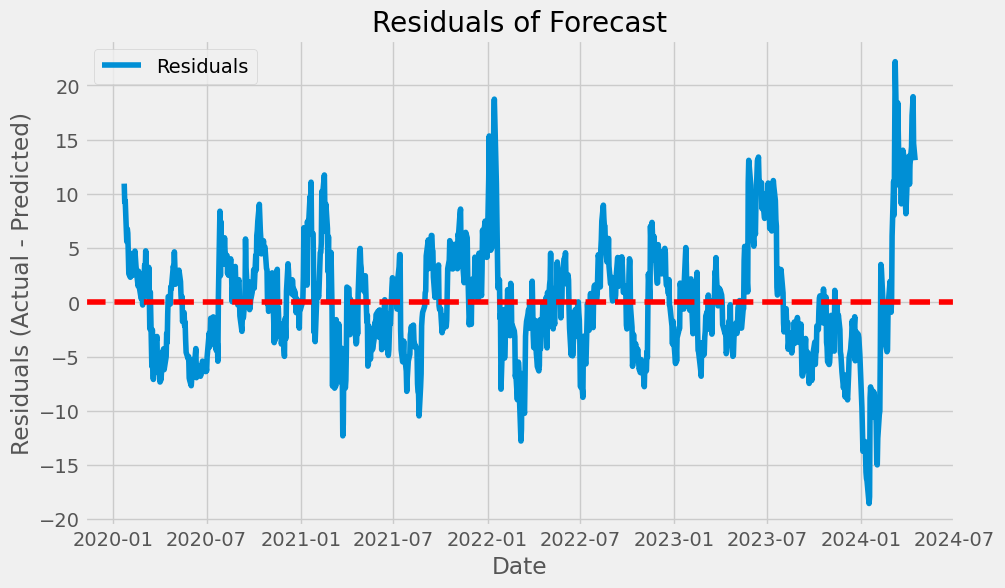

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(merged['ds'], merged['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

The residuals look far from white noice, we need to fine tune the parameters.

# Hypertuning the parameters

In [13]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = [] 
mapes = []

for params in all_params:
    m = Prophet(**params).fit(tsm_prophet_2020) 
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])


tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

22:07:27 - cmdstanpy - INFO - Chain [1] start processing
22:07:27 - cmdstanpy - INFO - Chain [1] done processing
22:07:38 - cmdstanpy - INFO - Chain [1] start processing
22:07:39 - cmdstanpy - INFO - Chain [1] done processing
22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
22:08:03 - cmdstanpy - INFO - Chain [1] start processing
22:08:03 - cmdstanpy - INFO - Chain [1] done processing
22:08:15 - cmdstanpy - INFO - Chain [1] start processing
22:08:15 - cmdstanpy - INFO - Chain [1] done processing
22:08:24 - cmdstanpy - INFO - Chain [1] start processing
22:08:25 - cmdstanpy - INFO - Chain [1] done processing
22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:33 - cmdstanpy - INFO - Chain [1] done processing
22:08:42 - cmdstanpy - INFO - Chain [1] start processing
22:08:42 - cmdstanpy - INFO - Chain [1] done processing
22:08:51 - cmdstanpy - INFO - Chain [1] start processing
22:08:51 - cmdstanpy - INFO - Chain [1]

In [15]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [16]:
m = Prophet(interval_width=0.95, weekly_seasonality=True,
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model = m.fit(tsm_prophet_2020)

22:12:40 - cmdstanpy - INFO - Chain [1] start processing
22:12:40 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

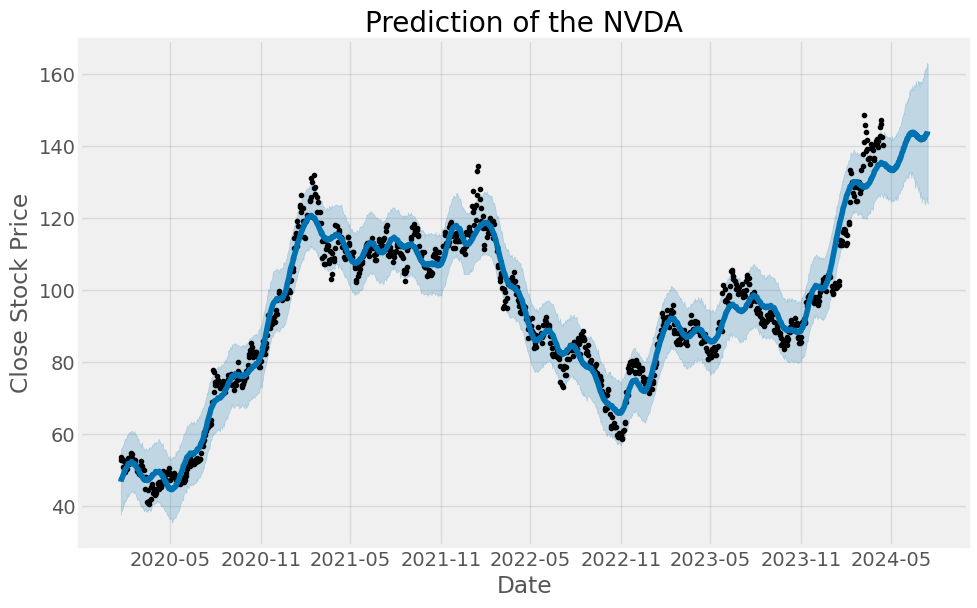

In [18]:
m.plot(forecast)
plt.title("Prediction of the TSM")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [19]:
merged_data = forecast[['ds', 'yhat']].merge(tsm_prophet_2020, on='ds')
merged_data['residuals'] = merged_data['y'] - merged_data['yhat']
merged_data['error'] = np.abs(merged_data['yhat'] - merged_data['y'])
mae = merged_data['error'].mean()

merged_data['percentage_error'] = np.abs((merged_data['yhat'] - merged_data['y']) / merged_data['y'])
mape = merged_data['percentage_error'].mean() * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 3.363845859984242
MAPE: 3.7872152027160357%


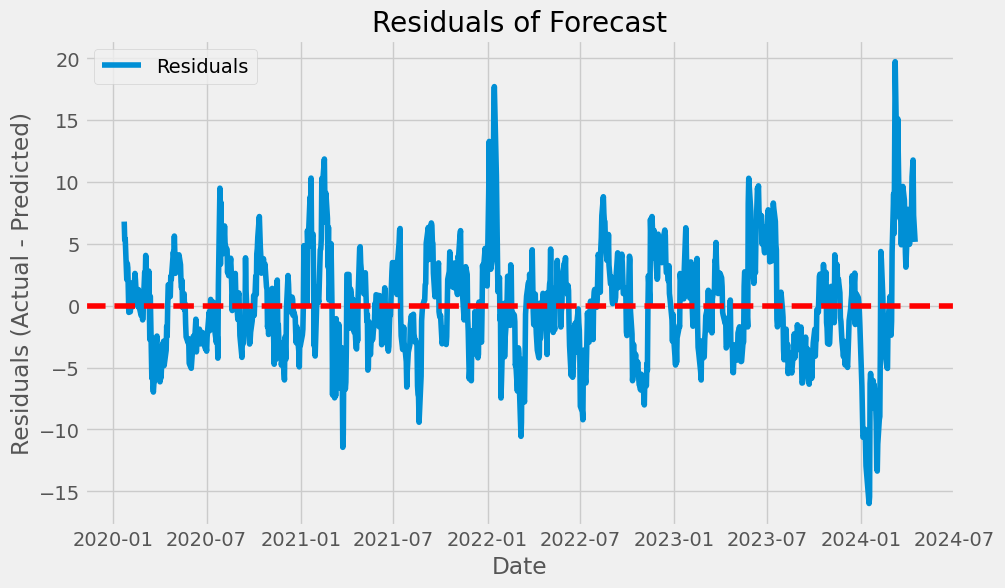

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

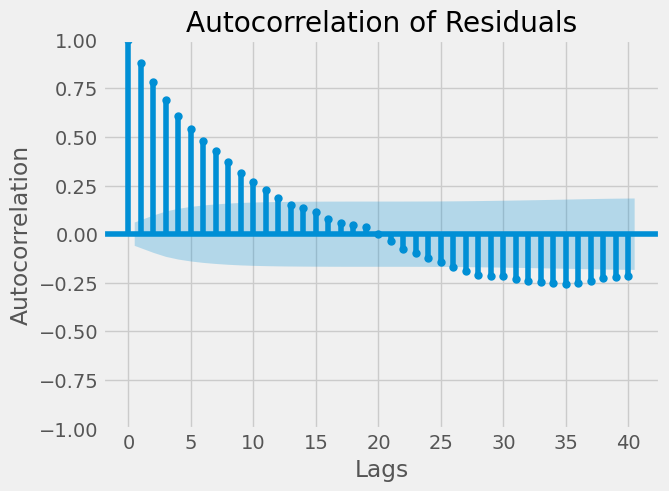

In [22]:
plot_acf(merged_data['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [23]:
stat, p = shapiro(merged_data['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.988, p=0.000
Probably not Gaussian


In [24]:
lb_test = acorr_ljungbox(merged_data['residuals'], lags=[10, 20], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,3478.545639,0.0
20,3644.721451,0.0


## Try boxcox transformation

In [25]:
df_boxcox = tsm_prophet_2020.copy()
data_transformed, best_lambda = stats.boxcox(df_boxcox['y'])
df_boxcox['y_transformed'] = data_transformed
df_boxcox = df_boxcox.drop(columns=['y'])
df_boxcox = df_boxcox.rename(columns={'y_transformed': 'y'})

In [26]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

all_params_box = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes_box = [] 
mapes_box = []

for params in all_params_box:
    m = Prophet(**params).fit(df_boxcox) 
    df_cv_box = cross_validation(m, horizon='90 days', parallel="processes")
    df_p_box = performance_metrics(df_cv_box, rolling_window=1)
    maes_box.append(df_p_box['mae'].values[0])
    mapes_box.append(df_p_box['mape'].values[0])


tuning_results_box = pd.DataFrame(all_params_box)
tuning_results_box['mae'] = maes_box
tuning_results_box['mape'] = mapes_box

22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:20 - cmdstanpy - INFO - Chain [1] start processing
22:15:20 - cmdstanpy - INFO - Chain [1] done processing
22:15:30 - cmdstanpy - INFO - Chain [1] start processing
22:15:30 - cmdstanpy - INFO - Chain [1] done processing
22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:42 - cmdstanpy - INFO - Chain [1] done processing
22:15:54 - cmdstanpy - INFO - Chain [1] start processing
22:15:54 - cmdstanpy - INFO - Chain [1] done processing
22:16:01 - cmdstanpy - INFO - Chain [1] start processing
22:16:01 - cmdstanpy - INFO - Chain [1] done processing
22:16:09 - cmdstanpy - INFO - Chain [1] start processing
22:16:09 - cmdstanpy - INFO - Chain [1] done processing
22:16:18 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing
22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1]

In [27]:
best_params_box = all_params_box[np.argmin(mapes_box)]
print(best_params_box)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [28]:
m_box = Prophet(interval_width=0.95, weekly_seasonality=True,
            changepoint_prior_scale=best_params_box['changepoint_prior_scale'],
            seasonality_prior_scale=best_params_box['seasonality_prior_scale'])
model = m_box.fit(df_boxcox)

22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:01 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future_box = m_box.make_future_dataframe(periods=90)
forecast_box = m_box.predict(future_box)
forecast_box['yhat_original_scale'] = inv_boxcox(forecast_box['yhat'], best_lambda)

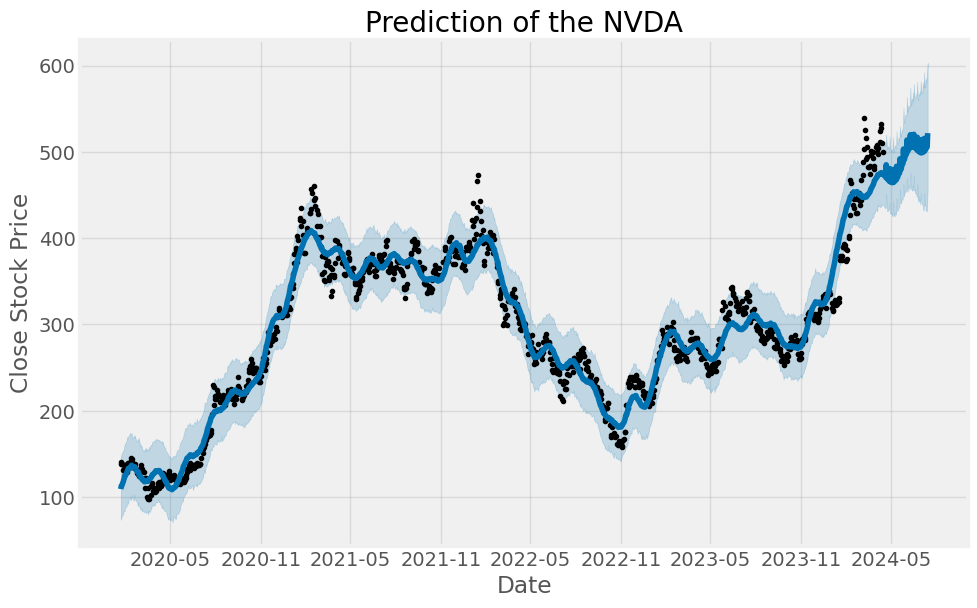

In [30]:
m_box.plot(forecast_box)
plt.title("Prediction of the TSM")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [32]:
merged_box = forecast_box[['ds', 'yhat_original_scale']].merge(tsm_prophet_2020, on='ds')
merged_box['residuals'] = merged_box['y'] - merged_box['yhat_original_scale']
merged_box['error'] = np.abs(merged_box['yhat_original_scale'] - merged_box['y'])
mae_box = merged_box['error'].mean()

merged_box['percentage_error'] = np.abs((merged_box['yhat_original_scale'] - merged_box['y']) / merged_box['y'])
mape_box = merged_box['percentage_error'].mean() * 100

print(f"MAE: {mae_box}")
print(f"MAPE: {mape_box}%")

MAE: 3.4465998413897094
MAPE: 3.9306804656583973%


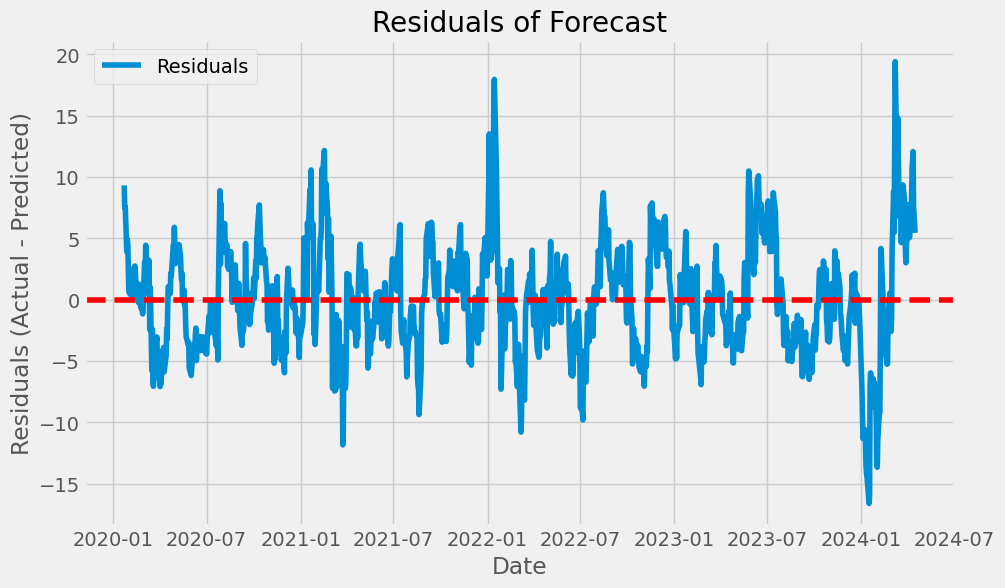

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(merged_box['ds'], merged_box['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

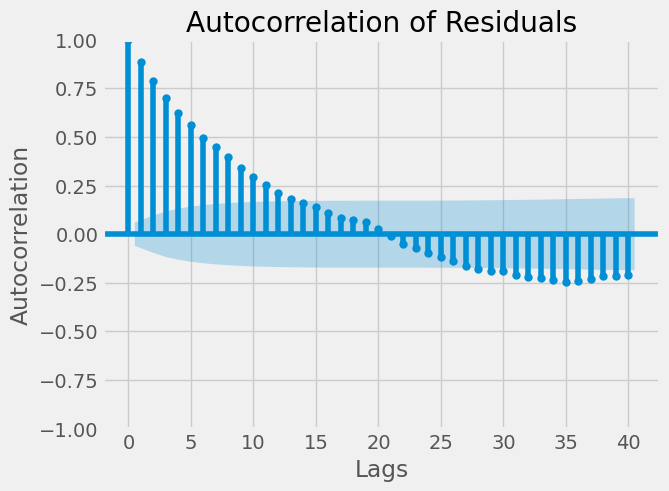

In [34]:
plot_acf(merged_box['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [35]:
stat, p = shapiro(merged_box['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.988, p=0.000
Probably not Gaussian


## Add Holidays to seasonality

In [36]:
m = Prophet(interval_width=0.95, weekly_seasonality=True, 
            changepoint_prior_scale=best_params['changepoint_prior_scale'], 
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
m.add_country_holidays(country_name='US')
model = m.fit(tsm_prophet_2020)

22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

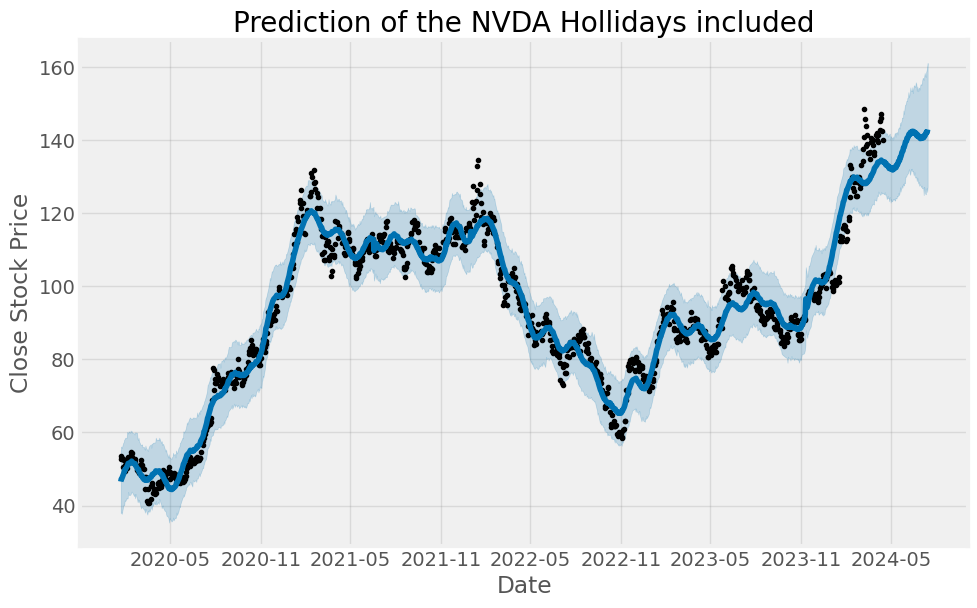

In [38]:
m.plot(forecast)
plt.title("Prediction of the NVDA Hollidays included")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [40]:
merged_data_hol = forecast[['ds', 'yhat']].merge(tsm_prophet_2020, on='ds')
merged_data_hol['residuals'] = merged_data_hol['y'] - merged_data_hol['yhat']
merged_data_hol['error'] = np.abs(merged_data_hol['yhat'] - merged_data_hol['y'])
mae_hol = merged_data_hol['error'].mean()

merged_data_hol['percentage_error'] = np.abs((merged_data_hol['yhat'] - merged_data_hol['y']) / merged_data_hol['y'])
mape_hol = merged_data['percentage_error'].mean() * 100

print(f"MAE: {mae_hol}")
print(f"MAPE: {mape_hol}%")

MAE: 3.4040060861787156
MAPE: 3.7872152027160357%


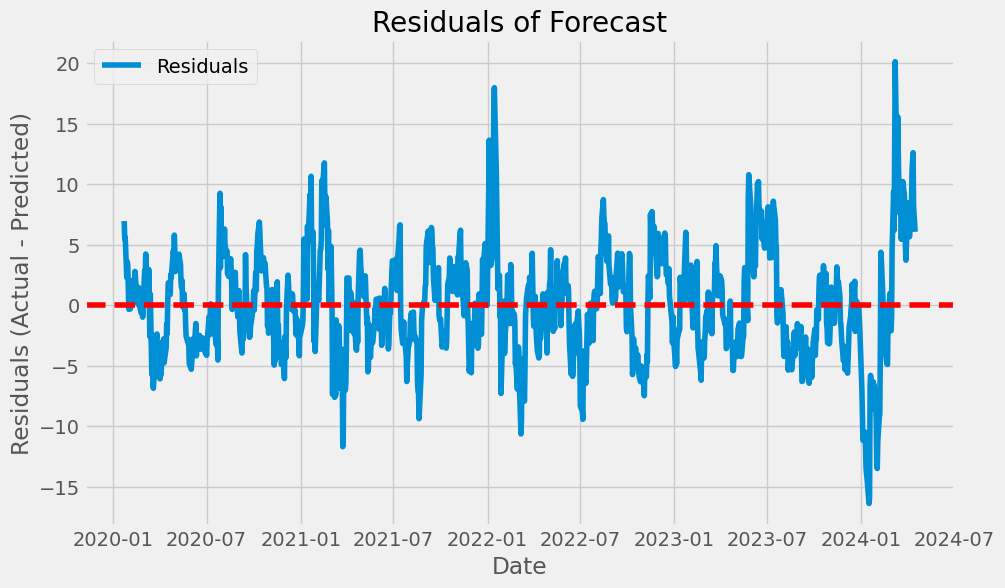

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data_hol['ds'], merged_data_hol['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

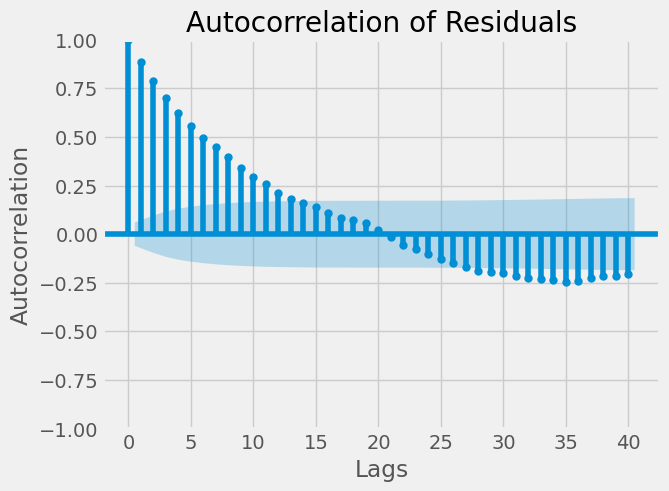

In [42]:
plot_acf(merged_data_hol['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [43]:
stat, p = shapiro(merged_data_hol['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.986, p=0.000
Probably not Gaussian


In [44]:
lb_test = acorr_ljungbox(merged_data_hol['residuals'], lags=[10, 20], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,3636.511645,0.0
20,3870.591836,0.0
